# Gaussian Mixture Model (NIR beers dataset)

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pymc3 as pm
import arviz as az
import seaborn as sns

az.style.use('arviz-darkgrid')

print('Running on PyMC3 v{}'.format(pm.__version__))

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC3 v3.7


## Import local utility functions and classes

In [2]:
import sys
sys.path.append('../utils')
import utils as utl
from data import Data

## Model configuration

In [3]:
# model mode
model_mode      = 'training'
#model_mode      = 'sampling'

# data filenames
data_filename   = '../../data/beers/NIR_beers.csv'
#data_filename   = '../../code/test/dummy_data_e.csv'
trace_filename  = './traces/trace_beers_nir'

## Load dataset, import and plot samples

In [4]:
# init dataset object
data_obj = Data(data_filename, 'label', -1)   
data_obj.data.head(5)
data = data_obj.data
data.head(5)

,1,2,3,4,5,6,7,8,9,10,...,692,693,694,695,696,697,698,699,700,label
37,-0.002702,-0.002589,-0.002469,-0.002357,-0.002263,-0.002178,-0.002092,-0.002007,-0.001918,-0.001821,...,0.681876,0.687409,0.692493,0.697092,0.701362,0.705330,0.708713,0.711816,0.714572,2
24,0.082634,0.082764,0.082909,0.083050,0.083181,0.083316,0.083467,0.083618,0.083743,0.083857,...,0.775477,0.781133,0.786250,0.791007,0.795365,0.799252,0.802854,0.806068,0.808856,1
25,0.082543,0.082673,0.082815,0.082957,0.083087,0.083224,0.083383,0.083539,0.083664,0.083778,...,0.776522,0.782052,0.787064,0.791726,0.796006,0.799876,0.803458,0.806597,0.809245,1
36,0.084691,0.084817,0.084956,0.085100,0.085233,0.085357,0.085497,0.085652,0.085798,0.085930,...,0.767531,0.772918,0.777904,0.782356,0.786504,0.790316,0.793723,0.796759,0.799428,1
34,-0.003401,-0.003281,-0.003153,-0.003031,-0.002922,-0.002821,-0.002724,-0.002629,-0.002529,-0.002418,...,0.680850,0.686305,0.691412,0.696080,0.700388,0.704347,0.707879,0.710993,0.713759,1


1: blue
2: red


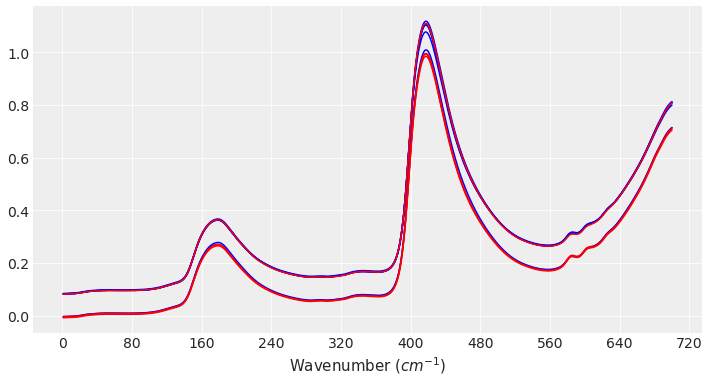

In [5]:
# list of class labels
class_labels = data_obj.get_class_labels()

# plot dataframe
utl.plot_data(data_obj, 10)

In [6]:
# number of samples from each class
print(data_obj.data[data_obj.label_column].value_counts())

1    28
2    16
Name: label, dtype: int64


In [7]:
# generate training and test sets
train_data, test_data = train_test_split(data_obj.data, train_size=0.8, random_state=42)

# rename the index
test_data.index = range(len(test_data))
train_data.index = range(len(train_data))

In [8]:
test_data.shape

(9, 701)

In [9]:
train_data.shape

(35, 701)

# Model definition
The following model is assumed:

\begin{equation}
\large A_{m} \sim \text{U} (0, max(Y)) \\
\large \mu_{m} \sim \mathcal{N}(\mu_{m}, 50) \\
\large \sigma_{m} \sim |\mathcal{N}(0, 100)| \\
\large \epsilon \sim |\mathcal{N}(0, 1)| \\
\large \theta = \sum\limits_{m=1}^M [A_m \cdot e^{-\frac{(x_n-\mu_m)^2}{2\cdot\sigma_m^2}}] + \alpha \cdot x_n + \beta \\
\large y \sim \mathcal{N}(\theta, \epsilon)
\end{equation}

In [10]:
# 1D array of X values
x_val = np.array(train_data.columns[:data_obj.non_data_columns], dtype='float32')

# 2D array containing Y values (observation data)
x_n = train_data.columns[:data_obj.non_data_columns]
x_s = train_data[x_n].values

In [11]:
peaks = [3]
traces = []
models = []

# prior on peak positions
#mu_p = [180, 330, 425, 600, 620, 720]
#peaks = [len(mu_p)]

for npeaks in peaks:
    if model_mode == 'training':
        print("training on " + str(npeaks) + " peaks")
    
    with pm.Model() as model:
        amp = pm.Uniform('amp', 0, x_s[0].max(), shape=(1,npeaks))
        mu = pm.Normal('mu', mu=np.linspace(x_val.min(), x_val.max(), npeaks), sd=50, 
                       shape=(1,npeaks), transform=pm.distributions.transforms.ordered)
        sigma = pm.HalfNormal('sigma', sd=100, shape=(1,npeaks))
        
        #alpha = pm.Normal('alpha', mu=0, sd=1)
        #beta = pm.Normal('beta', mu=0, sd=1)
        
        epsilon = pm.HalfNormal('epsilon', sd=1)

        #y = pm.Deterministic('y', (amp.T * np.exp(-(x_val - mu.T)**2/(2 * sigma.T**2))).sum(axis=0) +
        #                     alpha*x_val + beta)
        y = pm.Deterministic('y', (amp.T * np.exp(-(x_val - mu.T)**2/(2 * sigma.T**2))).sum(axis=0))
        
        y_pred = pm.Normal('y_pred', mu=y, sd=epsilon, observed=x_s)
        
        if model_mode == 'training':
            trace = pm.sample(2000, init='adapt_diag', random_seed=42)
            #trace = pm.sample(5000, init='adapt_diag')
            traces.append(trace)
            models.append(model)
        else:
            # load traces from trained model
            trace = pm.backends.text.load(trace_filename)
            traces.append(trace)
            models.append(model)
            break

training on 3 peaks


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma, mu, amp]
Sampling 2 chains: 100%|██████████| 5000/5000 [06:56<00:00, 11.99draws/s]
The acceptance probability does not match the target. It is 0.993869572293121, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9968431867565324, but should be close to 0.8. Try to increase the number of tuning steps.


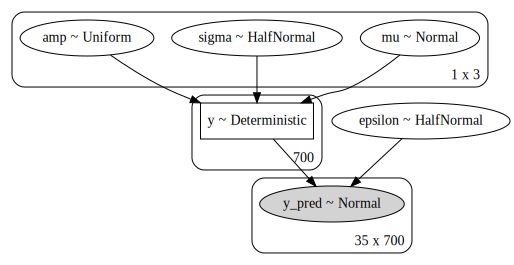

In [12]:
pm.model_to_graphviz(model)

# Model evaluation

In [13]:
#varnames = ['amp', 'mu', 'sigma', 'epsilon']
#coef = az.summary(traces[1], varnames)
#coef

In [14]:
#varnames = ['amp', 'mu', 'sigma', 'epsilon', 'alpha', 'beta']
#az.plot_trace(traces[0], varnames);

In [15]:
ppc_mm = [pm.sample_posterior_predictive(traces[i], samples=500, model=models[i]) for i in range(len(peaks))]

100%|██████████| 500/500 [00:01<00:00, 272.00it/s]


In [16]:
#data_ppc = az.from_pymc3(trace=traces[0], posterior_predictive=ppc_mm[0])
#ax = az.plot_ppc(data_ppc, figsize=(12, 6), mean=True)

## Compare distribution of data and posterior samples

In [17]:
#plt.figure(figsize=(12, 8))
#t = trace[:250]
#num = 5    
#for amp_, mu_, sigma_, alpha_, beta_, epsilon_ in zip(t['amp'][-num:], 
#                    t['mu'][-num:], t['sigma'][-num:], t['alpha'][-num:], t['beta'][-num:], t['epsilon'][-num:]):
#    plt.plot(x_val, (amp_.T * np.exp(-(x_val-mu_.T)**2/(2*sigma_.T**2))).sum(axis=0) + \
#             alpha_*x_val + beta_ + epsilon_*np.random.randn(), c='black', alpha=0.5, linewidth=1)

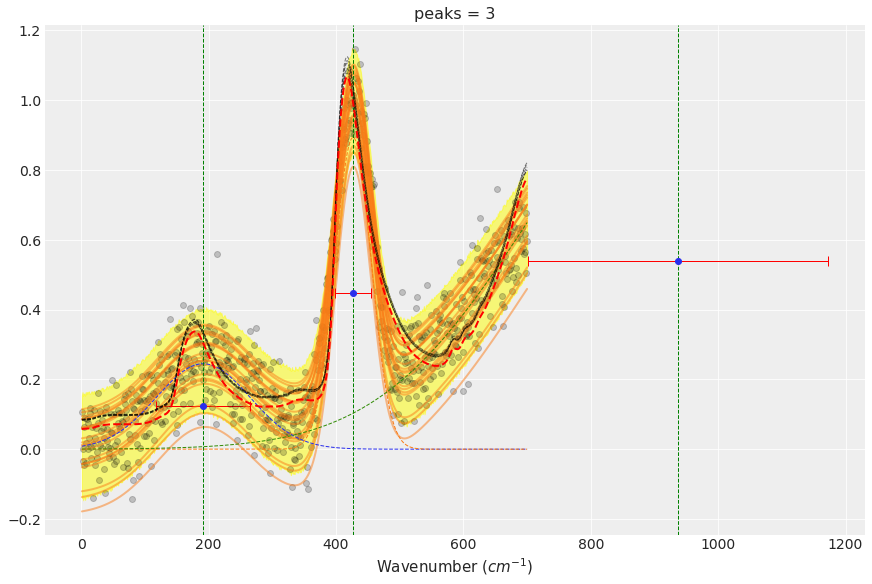

In [40]:
_, ax = plt.subplots(1, 1, figsize=(12, 8), constrained_layout=True)
ax = np.ravel(ax)
for idx, ppc_x in enumerate(ppc_mm):
    # plot samples from the posterior
    sp = ppc_x['y_pred']
    for i in range(1):
        ax[idx].plot(x_val, sp[i,0,:], 'o', color="black", linewidth=1, alpha=.2)
    
    # plot 94% HPD interval
    az.plot_hpd(x_val, ppc_x['y_pred'], smooth=False, color='yellow')
    
    # plot samples from the posterior model formula
    epsilon_ = traces[idx]['epsilon']
    for i in range(20):
        ax[idx].plot(x_val, traces[idx]['y'][i] + epsilon_[i]*np.random.randn(), color='C1', alpha=.5, linewidth=2)
    
    # plot mixture components 
    A = traces[idx]['amp'].mean(axis=0).flatten()
    M = traces[idx]['mu'].mean(axis=0).flatten()
    S = traces[idx]['sigma'].mean(axis=0).flatten()
    for j in range(len(A)):
        Y = A[j] * np.exp(-(x_val - M[j])**2/(2 * S[j]**2))
        ax[idx].plot(x_val, Y, '--', linewidth=1)
        ax[idx].axvline(M[j], linestyle='--', linewidth=1, color='g')
        ax[idx].errorbar(x=M[j], y=.5*A[j], xerr=S[j], fmt='o', 
                         ecolor='r', elinewidth=1, capsize=5, capthick=1)
        
    # plot samples from the dataset
    for i in range(5):
        y_val = train_data.values[i]
        ax[idx].plot(x_val, y_val[:data_obj.non_data_columns], '--', color="black", alpha=.5, linewidth=1)
        
    # plot the mean of the real data
    ax[idx].set(xlabel='Wavenumber ($cm^{-1}$)')
    ax[idx].plot(x_val, data_obj.data.iloc[:,:data_obj.non_data_columns].mean(), '--', color='red', linewidth=2);
    ax[idx].set_title('peaks = {}'.format(peaks[idx]))

In [19]:
if len(models)>1:
    comp = az.compare(dict(zip(peaks, traces)), method='BB-pseudo-BMA')
    print(comp)

In [20]:
if len(models)>1:
    az.plot_compare(comp);

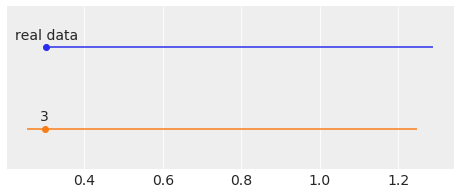

In [21]:
plt.figure(figsize=(8, 3))
data = [x_s]
dd = [ppc_mm[i]['y_pred'] for i in range(len(ppc_mm))]
data.extend(dd)
labels = ['real data']
pk = [str(peaks[i]) for i in range(len(peaks))]
labels.extend(pk)
for i, d in enumerate(data):
    mean = d.mean()
    err = np.percentile(d, [2.5, 97.5])
    plt.errorbar(mean, -i, xerr=[[-err[0]], [err[1]]], fmt='o')
    plt.text(mean, -i+0.1, labels[i], ha='center', fontsize=14)
plt.ylim([-i-0.5, 0.5])
plt.yticks([]);

In [22]:
if len(models)>1:
    for idx, trace in enumerate(traces):
        print(str(peaks[idx]) + " peaks, bfmi: " + str(az.bfmi(trace)))

In [23]:
for idx, ppc in enumerate(ppc_mm):
    print("--- " + str(peaks[idx]) + " peaks -----------\n" + str(az.r2_score(x_s, ppc['y_pred'])))

--- 3 peaks -----------
r2        0.898209
r2_std    0.005821
dtype: float64


In [24]:
#varnames = ['amp', 'mu', 'sigma', 'epsilon', 'alpha', 'beta']
varnames = ['amp', 'mu', 'sigma', 'epsilon']
for idx, trace in enumerate(traces):
    print("\n--- " + str(peaks[idx]) + " peaks ----------------------------------")
    coef = az.summary(trace, varnames)
    print(coef)


--- 3 peaks ----------------------------------
               mean     sd   hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  \
amp[0,0]      0.245  0.002    0.242    0.248      0.000    0.000    3478.0   
amp[0,1]      0.893  0.003    0.888    0.898      0.000    0.000    3204.0   
amp[0,2]      1.076  0.001    1.074    1.077      0.000    0.000    2210.0   
mu[0,0]     191.553  0.548  190.534  192.561      0.013    0.009    1701.0   
mu[0,1]     426.783  0.102  426.593  426.970      0.002    0.001    3174.0   
mu[0,2]     936.850  3.158  930.917  942.698      0.077    0.055    1670.0   
sigma[0,0]   73.578  0.778   72.086   74.972      0.015    0.010    2816.0   
sigma[0,1]   28.453  0.151   28.169   28.737      0.003    0.002    2063.0   
sigma[0,2]  235.472  2.362  231.068  239.781      0.058    0.041    1635.0   
epsilon       0.079  0.000    0.078    0.079      0.000    0.000    4547.0   

            ess_sd  ess_bulk  ess_tail  r_hat  
amp[0,0]    3475.0    3492.0    2850.0    1.0


--- 3 peaks ----------------------------------


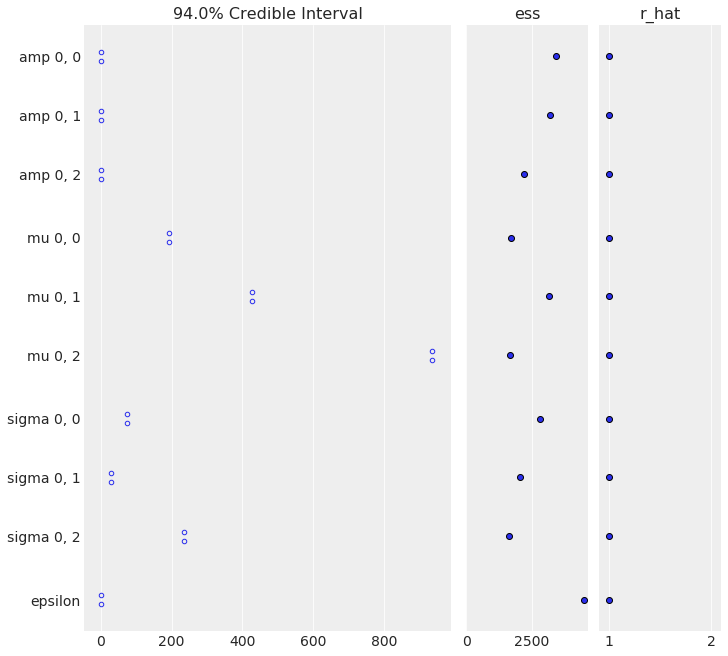

In [25]:
for idx, trace in enumerate(traces):
    print("\n--- " + str(peaks[idx]) + " peaks ----------------------------------")
#    az.plot_forest(trace, var_names = ['amp', 'mu', 'sigma', 'epsilon', 'alpha', 'beta'], r_hat=True, ess=True);
    az.plot_forest(trace, var_names = ['amp', 'mu', 'sigma', 'epsilon'], r_hat=True, ess=True);

## Save results

In [26]:
if model_mode == 'training':
    # save inference results
    pm.backends.text.dump(trace_filename, traces[0])